In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
!pip install deeplake[enterprise]

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 521.8/521.8 kB 9.5 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 135.9/135.9 kB 17.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 79.8/79.8 kB 11.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.7/6.7 MB 82.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.9/10.9 MB 70.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 72.7/72.7 kB 9.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.4/10.4 MB 87.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 132.7/132.7 kB 16.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 79.8/79.8 kB 10.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 52.8/52.8 kB 6.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 110.5/110.5 kB 15.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.3/134.3 kB 17.7 MB/s eta

In [3]:

import deeplake
import matplotlib.pyplot as plt
import numpy as np
import os
from sklearn.metrics import roc_auc_score, roc_curve
import time
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torchvision import transforms, models

In [4]:
test_ds = deeplake.load('hub://activeloop/nih-chest-xray-test')

/

Opening dataset in read-only mode as you don't have write permissions.


|

This dataset can be visualized in Jupyter Notebook by ds.visualize() or at https://app.activeloop.ai/activeloop/nih-chest-xray-test



/

hub://activeloop/nih-chest-xray-test loaded successfully.



In [5]:
image_transform = transforms.Compose([
  transforms.Resize((224, 224)),
  transforms.Grayscale(num_output_channels=1),
  transforms.ToTensor(),
  transforms.Normalize(mean=[0.5], std=[0.5]),
])

def findings_transform(findings_list):
  multi_hot_encoded = [0] * (15)
  for index in findings_list:
    multi_hot_encoded[index] = 1

  return torch.Tensor(multi_hot_encoded)

batch_size = 16
num_workers = 2

test_loader = test_ds.dataloader()\
                 .transform({'images': image_transform, 'findings': findings_transform})\
                 .batch(batch_size)\
                 .shuffle(False)\
                 .pytorch(num_workers = num_workers, decode_method={'images': 'pil'})

In [9]:
model = models.vgg16()
model.features[0] = nn.Conv2d(1, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)

num_labels = 15
in_features = model.classifier[6].in_features

in_features = 25088

classifier = nn.Sequential(
    nn.Linear(in_features, 1000),
    nn.ReLU(),
    nn.Linear(1000, num_labels),
    nn.Sigmoid()
)

model.classifier = classifier

In [7]:
def class_averaged_binary_cross_entropy(preds, targets):
  num_classes = 15
  loss = 0

  for c in range(num_classes):
    loss_c = F.binary_cross_entropy(preds[:, c], targets[:, c])
    loss += loss_c

  loss /= num_classes

  return loss

In [8]:
def load_model(result_file_model, model_to_load, model, epoch, device):
    model_save_path = f'{result_file_model}/{model_name}_checkpoint_epoch_{epoch}.pt'
    model.load_state_dict(torch.load(model_save_path, map_location=device))
    print(f'Model loaded from {model_save_path}')
    return model

In [21]:
label_names = test_ds.findings.info.class_names
print(label_names)

['No Finding', 'Hernia', 'Emphysema', 'Nodule', 'Pneumonia', 'Consolidation', 'Cardiomegaly', 'Effusion', 'Mass', 'Pleural_Thickening', 'Atelectasis', 'Pneumothorax', 'Fibrosis', 'Infiltration', 'Edema']


In [11]:
model_name = "SSN_VGG16"
result_file_model = "/content/drive/MyDrive/SSN_Projekt/Saved_Models/"
epoch = 10

criterion = class_averaged_binary_cross_entropy

device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
print(f'Running on {device}')

loaded_model = load_model(result_file_model, model_name, model, epoch, device)
loaded_model.to(device)
loaded_model.eval()

Running on cuda
Model loaded from /content/drive/MyDrive/SSN_Projekt/Saved_Models//SSN_VGG16_checkpoint_epoch_10.pt


VGG(
  (features): Sequential(
    (0): Conv2d(1, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0

In [12]:
# Containers to store predictions and true labels
all_preds = torch.tensor([]).to(device)
all_labels = torch.tensor([]).to(device)

# Go through the train_loader
with torch.no_grad():
    for data, label in test_loader:
        data, label = data.to(device), label.to(device)
        output = model(data)
        all_preds = torch.cat((all_preds, output), dim=0)
        all_labels = torch.cat((all_labels, label), dim=0)

In [25]:
all_preds = all_preds.cpu()
print(all_preds)

tensor([[5.6241e-01, 3.9772e-03, 2.6486e-02,  ..., 5.6543e-02, 1.6930e-01,
         4.3793e-03],
        [7.3009e-01, 5.1735e-04, 2.3649e-03,  ..., 2.4767e-02, 9.0145e-02,
         5.8502e-04],
        [6.3731e-01, 3.4990e-03, 6.1253e-03,  ..., 1.9635e-02, 1.3628e-01,
         4.1449e-03],
        ...,
        [9.0244e-01, 2.0283e-04, 4.9351e-04,  ..., 5.8511e-03, 7.0991e-02,
         6.5998e-05],
        [8.7805e-01, 3.4215e-04, 9.5000e-04,  ..., 7.7947e-03, 7.3703e-02,
         1.7209e-04],
        [8.3294e-01, 4.5103e-04, 7.6521e-04,  ..., 6.2712e-03, 8.1507e-02,
         7.9595e-04]])


In [27]:
all_labels = all_labels.cpu()
print(all_labels)

tensor([[0., 1., 0.,  ..., 0., 0., 0.],
        [0., 1., 0.,  ..., 0., 0., 0.],
        [0., 1., 0.,  ..., 0., 0., 0.],
        ...,
        [1., 0., 0.,  ..., 0., 0., 0.],
        [1., 0., 0.,  ..., 0., 0., 0.],
        [1., 0., 0.,  ..., 0., 0., 0.]])


In [16]:
def accuracy_multi(preds, targs, thresh=0.5):
    preds = (preds > thresh).float()
    return (preds == targs).float().mean()

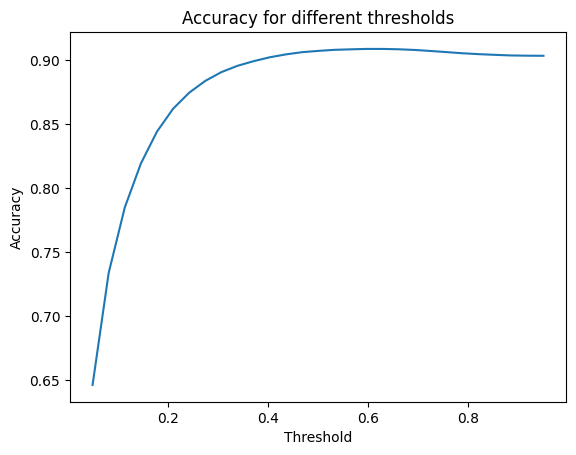

In [17]:
thresholds = torch.linspace(0.05, 0.95, 29).cpu().numpy()
accuracies = [accuracy_multi(all_preds, all_labels, thresh=i).cpu().numpy() for i in thresholds]

plt.plot(thresholds, accuracies)
plt.xlabel("Threshold")
plt.ylabel("Accuracy")
plt.title("Accuracy for different thresholds")
plt.show()

In [32]:
threshold = 0.55
all_preds_binary = (all_preds > threshold).float().cpu()

In [33]:
all_preds_binary

tensor([[1., 0., 0.,  ..., 0., 0., 0.],
        [1., 0., 0.,  ..., 0., 0., 0.],
        [1., 0., 0.,  ..., 0., 0., 0.],
        ...,
        [1., 0., 0.,  ..., 0., 0., 0.],
        [1., 0., 0.,  ..., 0., 0., 0.],
        [1., 0., 0.,  ..., 0., 0., 0.]])

Micro-averaged ROC AUC: 0.8181241607396809
Macro-averaged ROC AUC: 0.6945161219190121
ROC AUC for label No Finding: 0.6963869634116959
ROC AUC for label Hernia: 0.6979861978430711
ROC AUC for label Emphysema: 0.6590357384399297
ROC AUC for label Nodule: 0.5920596283881596
ROC AUC for label Pneumonia: 0.6169772384100884
ROC AUC for label Consolidation: 0.697112378646147
ROC AUC for label Cardiomegaly: 0.806906292879808
ROC AUC for label Effusion: 0.7632311087046295
ROC AUC for label Mass: 0.6732245319709803
ROC AUC for label Pleural_Thickening: 0.6840070005562477
ROC AUC for label Atelectasis: 0.6951263383171232
ROC AUC for label Pneumothorax: 0.7162978125992301
ROC AUC for label Fibrosis: 0.6792805139499325
ROC AUC for label Infiltration: 0.6627049246542471
ROC AUC for label Edema: 0.7774051600138909


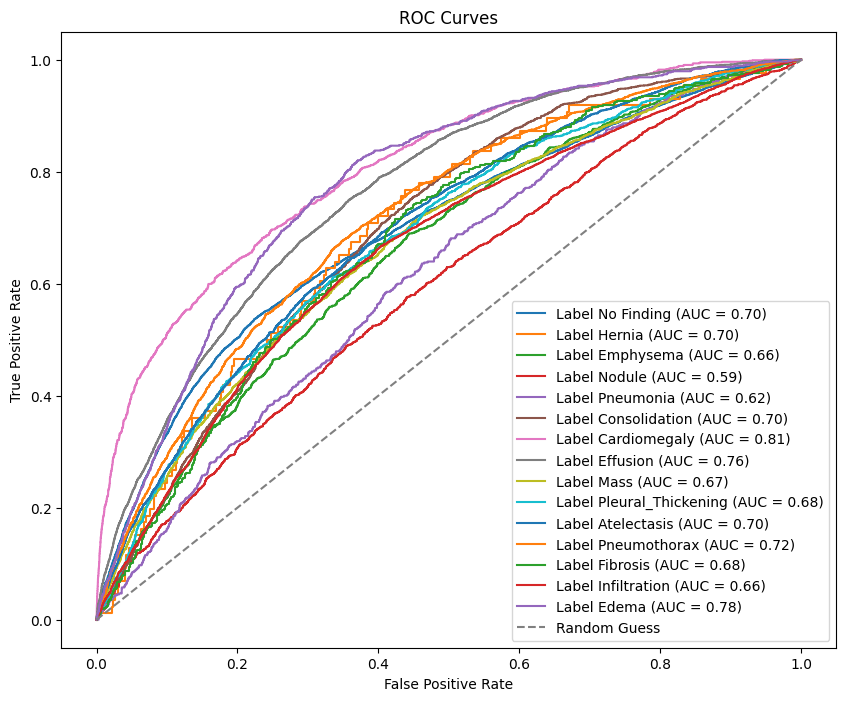

In [28]:
micro_auc_score = roc_auc_score(all_labels, all_preds, average='micro')
print(f'Micro-averaged ROC AUC: {micro_auc_score}')

macro_auc_score = roc_auc_score(all_labels, all_preds, average='macro')
print(f'Macro-averaged ROC AUC: {macro_auc_score}')

num_labels = len(label_names)
plt.figure(figsize=(10, 8))

per_class_auc_scores = []

for label_index in range(num_labels):
  try:
    auc_score = roc_auc_score(all_labels[:, label_index], all_preds[:, label_index])
    per_class_auc_scores.append(auc_score)
    print(f'ROC AUC for label {label_names[label_index]}: {auc_score}')

    fpr, tpr, _ = roc_curve(all_labels[:, label_index], all_preds[:, label_index])
    plt.plot(fpr, tpr, label=f'Label {label_names[label_index]} (AUC = {auc_score:.2f})')
  except ValueError:
    print(f'ROC AUC for label {label_names[label_index]}: Not Defined (No positive examples in labels)')
    per_class_auc_scores.append(None)

plt.plot([0, 1], [0, 1], color='gray', linestyle='--', label='Random Guess')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curves')
plt.legend(loc="lower right")
plt.show()

In [29]:
mse_loss = nn.MSELoss()
total_loss = 0
total_losses = torch.zeros(all_preds.size(1))
num_samples = 0

loss = mse_loss(all_preds, all_labels)
total_loss += loss.item() * all_preds.size(0)

# loop for each label
for i in range(all_preds.size(1)):
  preds = all_preds[:, i]  # Select predictions for a specific label
  labels = all_labels[:, i]  # Select target labels for the same label

  loss = mse_loss(preds, labels)
  total_losses[i] += torch.sum(loss).item()

num_samples += all_preds.size(0)

average_loss = total_loss / num_samples
average_losses = total_losses / num_samples

In [30]:
mse, mse_per_label = average_loss, average_losses

print(f"Mean Squared Error (MSE): {mse:.4f}")
for label_index, mse in enumerate(mse_per_label):
    print(f"Mean Squared Error (MSE) for Label {label_index}: {mse:.9f}")

Mean Squared Error (MSE): 0.0729
Mean Squared Error (MSE) for Label 0: 0.000008425
Mean Squared Error (MSE) for Label 1: 0.000000131
Mean Squared Error (MSE) for Label 2: 0.000001599
Mean Squared Error (MSE) for Label 3: 0.000002317
Mean Squared Error (MSE) for Label 4: 0.000000830
Mean Squared Error (MSE) for Label 5: 0.000002501
Mean Squared Error (MSE) for Label 6: 0.000001394
Mean Squared Error (MSE) for Label 7: 0.000005037
Mean Squared Error (MSE) for Label 8: 0.000002440
Mean Squared Error (MSE) for Label 9: 0.000001647
Mean Squared Error (MSE) for Label 10: 0.000004128
Mean Squared Error (MSE) for Label 11: 0.000003613
Mean Squared Error (MSE) for Label 12: 0.000000662
Mean Squared Error (MSE) for Label 13: 0.000006689
Mean Squared Error (MSE) for Label 14: 0.000001325


In [35]:
from sklearn.metrics import multilabel_confusion_matrix

cm = multilabel_confusion_matrix(all_labels, all_preds_binary)
print(cm)

[[[12265  3470]
  [ 4618  5243]]

 [[25510     0]
  [   86     0]]

 [[24503     0]
  [ 1093     0]]

 [[23973     0]
  [ 1623     0]]

 [[25041     0]
  [  555     0]]

 [[23781     0]
  [ 1815     0]]

 [[24508    19]
  [ 1033    36]]

 [[20576   362]
  [ 4172   486]]

 [[23845     3]
  [ 1748     0]]

 [[24453     0]
  [ 1143     0]]

 [[22317     0]
  [ 3279     0]]

 [[22931     0]
  [ 2665     0]]

 [[25161     0]
  [  435     0]]

 [[19419    65]
  [ 6045    67]]

 [[24671     0]
  [  925     0]]]


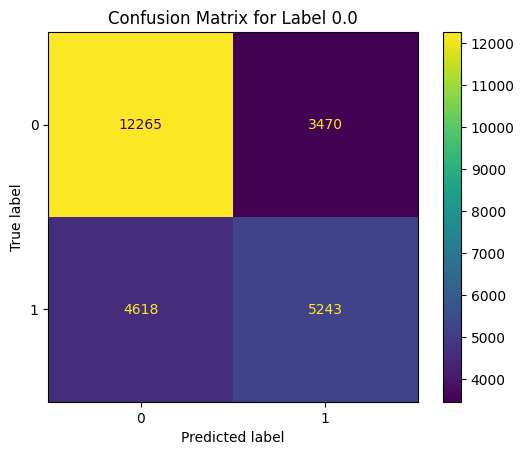

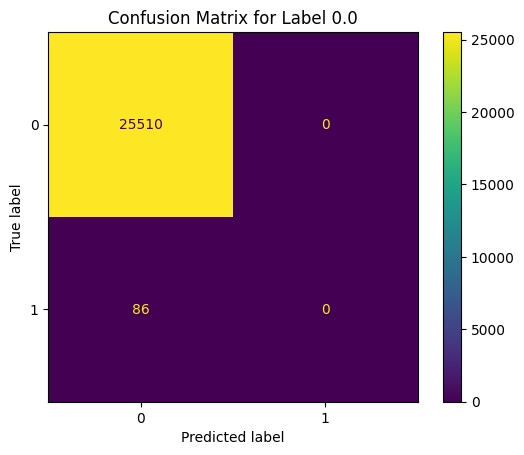

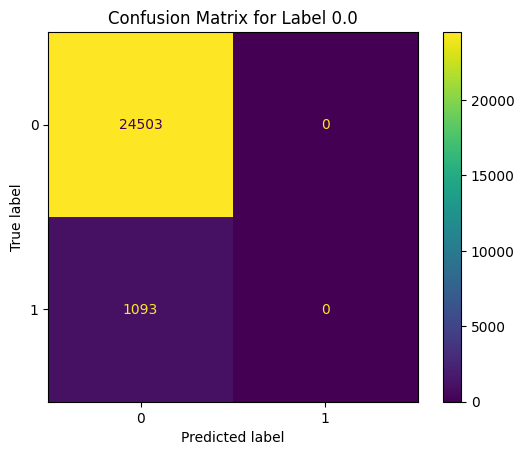

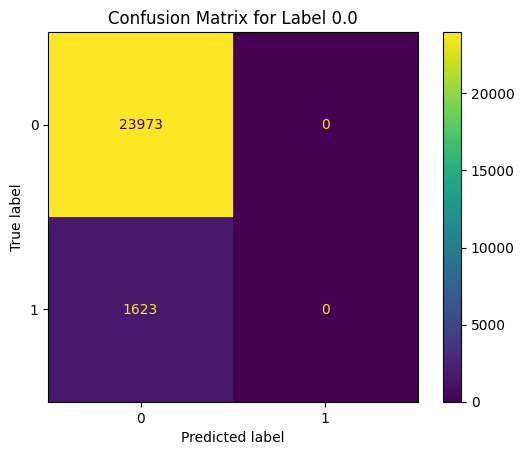

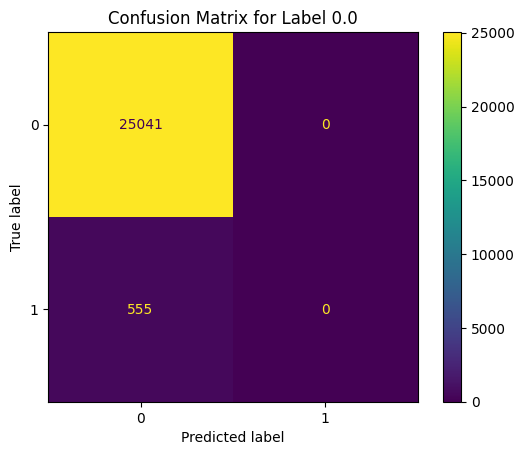

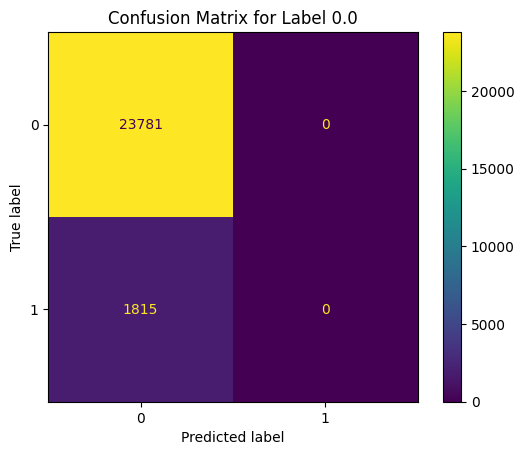

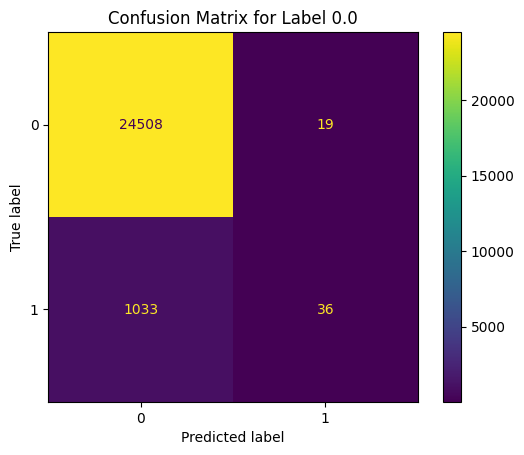

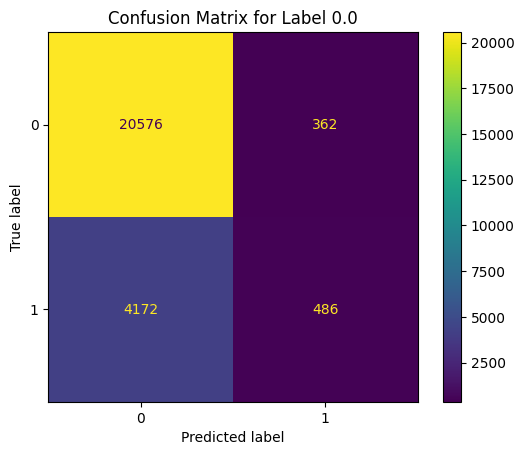

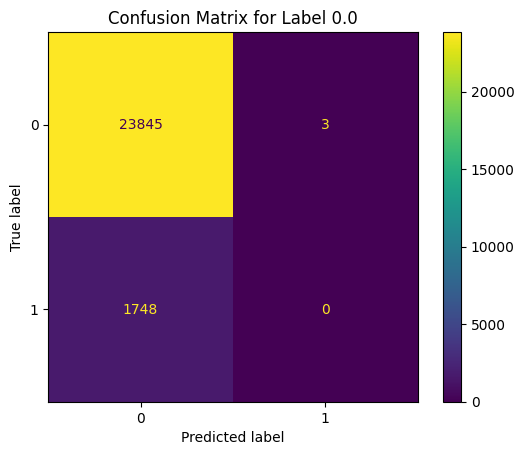

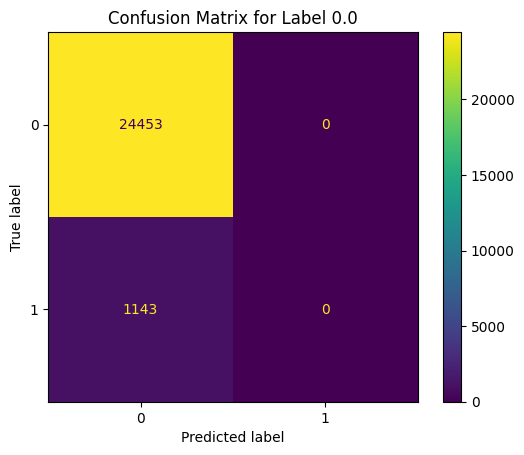

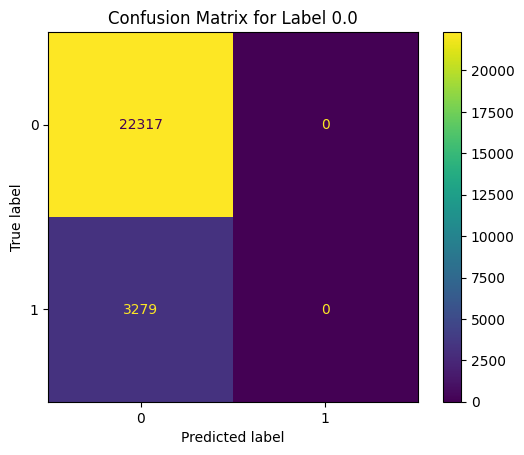

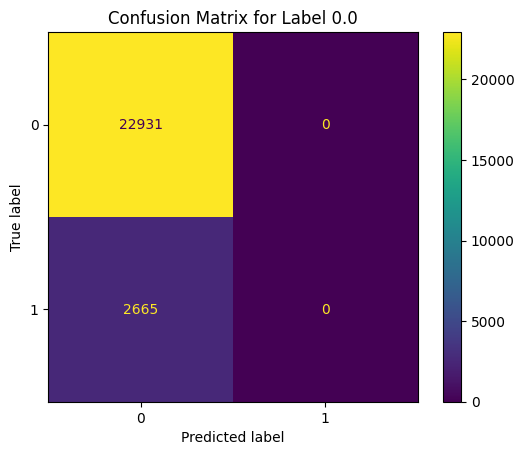

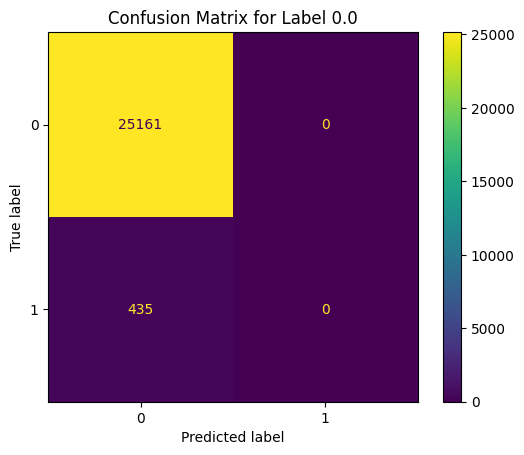

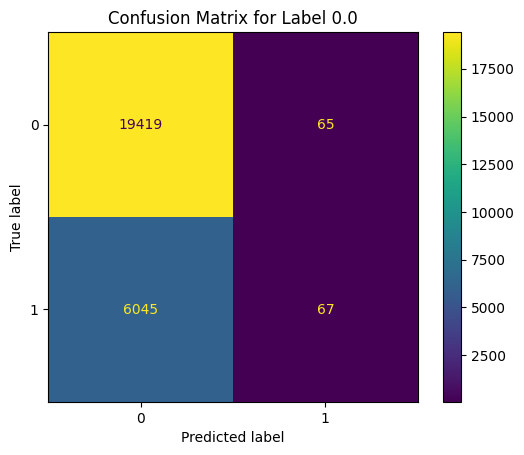

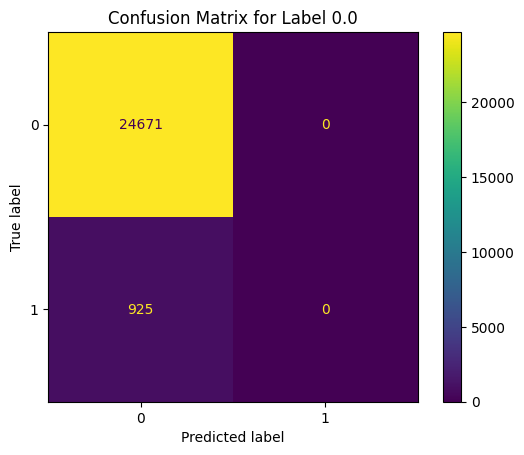

In [36]:
from sklearn.metrics import ConfusionMatrixDisplay

for i in range(cm.shape[0]):
    display = ConfusionMatrixDisplay(confusion_matrix=cm[i])
    fig, ax = plt.subplots()
    display.plot(ax=ax)
    plt.title(f"Confusion Matrix for Label {labels[i]}")
    plt.show()

In [37]:
def calculate_specificity(confusion_matrix):
    true_negatives = confusion_matrix[0, 0]
    false_positives = confusion_matrix[0, 1]
    specificity = true_negatives / (true_negatives + false_positives)
    return specificity

In [38]:
def calculate_sensitivity(confusion_matrix):
    true_positives = confusion_matrix[1, 1]
    false_negatives = confusion_matrix[1, 0]
    sensitivity = true_positives / (true_positives + false_negatives)
    return sensitivity

In [39]:
for i in range(len(cm)):
    specificities = calculate_specificity(cm[i])
    sensitivities = calculate_sensitivity(cm[i])
    print(f"Label {labels[i]}: Specificity = {specificities:.4f}, Sensitivity = {sensitivities:.4f}")

Label 0.0: Specificity = 0.7795, Sensitivity = 0.5317
Label 0.0: Specificity = 1.0000, Sensitivity = 0.0000
Label 0.0: Specificity = 1.0000, Sensitivity = 0.0000
Label 0.0: Specificity = 1.0000, Sensitivity = 0.0000
Label 0.0: Specificity = 1.0000, Sensitivity = 0.0000
Label 0.0: Specificity = 1.0000, Sensitivity = 0.0000
Label 0.0: Specificity = 0.9992, Sensitivity = 0.0337
Label 0.0: Specificity = 0.9827, Sensitivity = 0.1043
Label 0.0: Specificity = 0.9999, Sensitivity = 0.0000
Label 0.0: Specificity = 1.0000, Sensitivity = 0.0000
Label 0.0: Specificity = 1.0000, Sensitivity = 0.0000
Label 0.0: Specificity = 1.0000, Sensitivity = 0.0000
Label 0.0: Specificity = 1.0000, Sensitivity = 0.0000
Label 0.0: Specificity = 0.9967, Sensitivity = 0.0110
Label 0.0: Specificity = 1.0000, Sensitivity = 0.0000


In [40]:
val_accuracy = accuracy_multi(all_preds, all_labels, threshold).item()
print(f'Epoch 1, Validation Accuracy: {val_accuracy}')

Epoch 1, Validation Accuracy: 0.9084388017654419


In [41]:
from sklearn.metrics import f1_score, precision_score, recall_score

In [42]:
# Concatenate the results
all_preds_np = all_preds.cpu().numpy()
all_labels_np = all_labels.cpu().numpy()

# Calculate and print the F1 score, precision, and recall for each label
num_labels = all_labels_np.shape[1]
for label_index in range(num_labels):
    f1 = f1_score(all_labels_np[:, label_index], all_preds_np[:, label_index] > threshold, zero_division=1)
    precision = precision_score(all_labels_np[:, label_index], all_preds_np[:, label_index] >threshold, zero_division=1)
    recall = recall_score(all_labels_np[:, label_index], all_preds_np[:, label_index] > threshold, zero_division=1)

    print(f'Label {label_index} - F1 score: {f1}, Precision: {precision}, Recall: {recall}')

# Calculate micro and macro averaged F1 score, precision, and recall
micro_f1 = f1_score(all_labels_np, all_preds_np > threshold, average='micro', zero_division=1)
macro_f1 = f1_score(all_labels_np, all_preds_np > threshold, average='macro', zero_division=1)
micro_precision = precision_score(all_labels_np, all_preds_np > threshold, average='micro', zero_division=1)
macro_precision = precision_score(all_labels_np, all_preds_np > threshold, average='macro', zero_division=1)
micro_recall = recall_score(all_labels_np, all_preds_np > threshold, average='micro', zero_division=1)
macro_recall = recall_score(all_labels_np, all_preds_np > threshold, average='macro', zero_division=1)

print(f'Micro-averaged - F1 score: {micro_f1}, Precision: {micro_precision}, Recall: {micro_recall}')
print(f'Macro-averaged - F1 score: {macro_f1}, Precision: {macro_precision}, Recall: {macro_recall}')

Label 0 - F1 score: 0.5645526004091741, Precision: 0.601744519683232, Recall: 0.5316904979211033
Label 1 - F1 score: 0.0, Precision: 1.0, Recall: 0.0
Label 2 - F1 score: 0.0, Precision: 1.0, Recall: 0.0
Label 3 - F1 score: 0.0, Precision: 1.0, Recall: 0.0
Label 4 - F1 score: 0.0, Precision: 1.0, Recall: 0.0
Label 5 - F1 score: 0.0, Precision: 1.0, Recall: 0.0
Label 6 - F1 score: 0.06405693950177936, Precision: 0.6545454545454545, Recall: 0.03367633302151544
Label 7 - F1 score: 0.17653468942971307, Precision: 0.5731132075471698, Recall: 0.10433662516101332
Label 8 - F1 score: 0.0, Precision: 0.0, Recall: 0.0
Label 9 - F1 score: 0.0, Precision: 1.0, Recall: 0.0
Label 10 - F1 score: 0.0, Precision: 1.0, Recall: 0.0
Label 11 - F1 score: 0.0, Precision: 1.0, Recall: 0.0
Label 12 - F1 score: 0.0, Precision: 1.0, Recall: 0.0
Label 13 - F1 score: 0.021460602178090968, Precision: 0.5075757575757576, Recall: 0.010962041884816753
Label 14 - F1 score: 0.0, Precision: 1.0, Recall: 0.0
Micro-average

In [43]:
from sklearn.metrics import hamming_loss, jaccard_score

# Calculate Hamming Loss
hamming_loss_value = hamming_loss(all_labels_np, all_preds_np > threshold)
print(f'Hamming Loss: {hamming_loss_value}')

# Calculate Jaccard Index (Intersection over Union)
jaccard_index = jaccard_score(all_labels_np, all_preds_np > threshold, average='micro')
print(f'Jaccard Index: {jaccard_index}')


Hamming Loss: 0.09156118143459915
Jaccard Index: 0.1422924901185771


In [44]:
# Calculate Exact Match (Accuracy Exact Match)
exact_match = (all_labels_np == (all_preds_np > threshold)).all(axis=1).mean()
print(f'Exact Match (Accuracy Exact Match): {exact_match}')

Exact Match (Accuracy Exact Match): 0.21182997343334897
